# Model Training

## Configuration (One Time Only

In [1]:
pip install pandas scikit-learn lightgbm matplotlib seaborn joblib XGBoost

Note: you may need to restart the kernel to use updated packages.


# Whole Code

In [2]:
!pip install category_encoders


In [11]:
!pip install --upgrade scikit-learn xgboost

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 1.4 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.7 MB 1.5 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/8.7 MB 1.5 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.7 MB 1.5 MB/s eta 0:00:06
   ------- -------------------------------- 1.6/8.7 MB 1.4 MB/s eta 0:00:06
   -------- ------------------------------- 1.8/8.7 MB 1.4 MB/s eta 0:00:05
   --------- ------------------------------ 2.1/8.7 MB 1.4 MB/s eta 0:00:05
   ------------ --------------------------- 2.6/8.7 MB 1.4 MB/s eta 0:00:05
   ------------- -------------------------- 2.9/8.7 MB 1.4 MB/s eta 0:00:05
   -------------- ------------------------- 3.1/8.7 MB 1.5 MB/s eta 0:00:04
   --------------- ------------------------ 3.4/8.7 MB 1.5 MB/s eta 0:00:04
   ---------------- ------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoviz 0.1.905 requires xgboost<1.7,>=0.82, but you have xgboost 3.1.1 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


Loaded dataset with shape: (4033120, 28)
Initial feature set shape after dropping IDs: (4033120, 13)
Remaining features: ['Unnamed: 0', 'gender', 'lat', 'long', 'city_pop', 'acct_num', 'profile', 'category', 'amt', 'merchant', 'merch_lat', 'merch_long', 'transaction_time']

Identified 4 categorical and 8 numerical columns.
Completed imputation for missing values.
Final feature matrix shape after encoding and scaling: (4033120, 729)

Train set shape: (3226496, 729), Test set shape: (806624, 729)
Features after removing zero-variance columns: 729
Selected 729 features via model importance.

Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best cross-validation ROC AUC: 0.9826

Saving model and preprocessing objects...
All components saved successfully.

=== FINAL MODEL PERFORMANCE ON TEST SET 

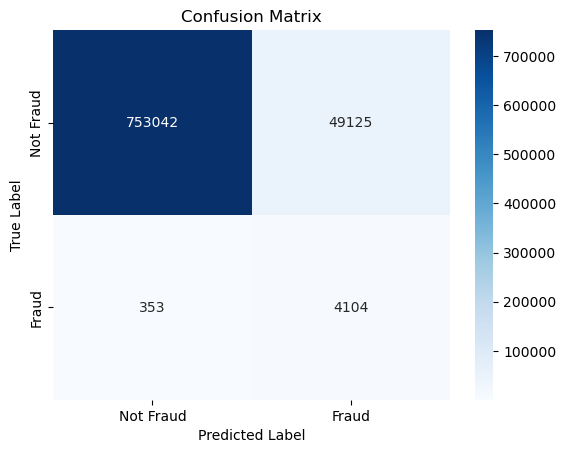

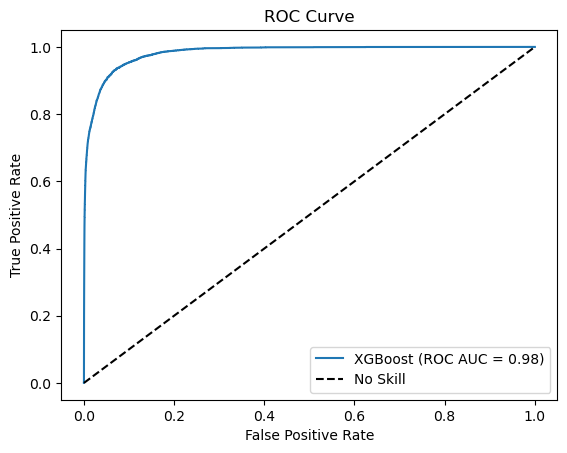

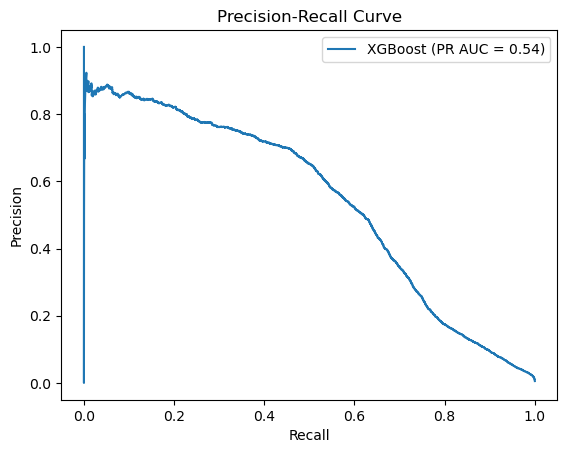

In [1]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
)
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# =============================================================================
# STEP 1: LOAD DATA
# =============================================================================
# FIX: Corrected the filename from "cleansed_df.pkl" to "cleansing_df.pkl"
try:
    df = pd.read_pickle("cleansed_df.pkl")
    print(f"Loaded dataset with shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'cleansing_df.pkl' not found. Please ensure the file is in the correct directory.")
    exit()

# =============================================================================
# STEP 2: FEATURE ENGINEERING
# =============================================================================
# IMPROVEMENT: Extract valuable features from datetime before dropping the raw column.
# Fraud patterns often depend heavily on time.
if 'trans_date_trans_time' in df.columns:
    print("Performing feature engineering on datetime column...")
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek # Monday=0, Sunday=6
    df['is_weekend'] = (df['trans_date_trans_time'].dt.dayofweek >= 5).astype(int)
    print("Created 'hour', 'day_of_week', and 'is_weekend' features.")

# =============================================================================
# STEP 3: DEFINE TARGET AND FEATURES
# =============================================================================
target_col = "is_fraud"
y = df[target_col]
X = df.drop(columns=[target_col])

# Define columns to drop. We keep datetime for now to engineer features.
# We also drop personal identifiers and high-cardinality columns that are hard to encode.
cols_to_drop = [
    'cc_num', 'ssn', 'first', 'last', 'street', 'city', 'state', 'zip', 'job',
    'trans_num', 'unix_time', 'dob', 'trans_date', 'trans_time', 'trans_date_trans_time'
]
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns], errors="ignore")
print(f"Initial feature set shape after dropping IDs: {X.shape}")
print("Remaining features:", X.columns.tolist())

# =============================================================================
# STEP 4: PREPROCESSING (IMPUTATION, ENCODING, SCALING)
# =============================================================================
# Identify column types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
print(f"\nIdentified {len(cat_cols)} categorical and {len(num_cols)} numerical columns.")

# FIX: Robustly handle missing data separately for numeric and categorical types
# This prevents converting numeric columns to objects.
# Impute numerical columns with the median (robust to outliers)
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Impute categorical columns with a constant "Missing" value
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

print("Completed imputation for missing values.")

# One-Hot Encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = encoder.fit_transform(X[cat_cols])

# Standard Scaling for numerical features
# Using with_mean=False is good practice for sparse matrices to preserve sparsity
scaler = StandardScaler(with_mean=False)
X_num = scaler.fit_transform(X[num_cols])
X_num = csr_matrix(X_num) # Convert to sparse matrix

# Combine processed numerical and categorical features
X_final = hstack([X_num, X_cat]).tocsr()
print(f"Final feature matrix shape after encoding and scaling: {X_final.shape}")

# =============================================================================
# STEP 5: SPLIT DATA
# =============================================================================
# Using stratify=y is crucial for imbalanced datasets like fraud detection
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# =============================================================================
# STEP 6: FEATURE SELECTION
# =============================================================================
# 1. Remove zero-variance features
vt = VarianceThreshold(threshold=0.0)
X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)
print(f"Features after removing zero-variance columns: {X_train_vt.shape[1]}")

# 2. Select features based on XGBoost importance
# scale_pos_weight is essential for training on imbalanced data
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_fs = XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', # Area Under PR Curve is great for imbalance
    random_state=42, scale_pos_weight=scale_pos_weight, n_estimators=100, max_depth=4, n_jobs=-1
)
xgb_fs.fit(X_train_vt, y_train)

selector = SelectFromModel(xgb_fs, prefit=True, threshold="median")
X_train_sel = selector.transform(X_train_vt)
X_test_sel = selector.transform(X_test_vt)
print(f"Selected {X_train_sel.shape[1]} features via model importance.")

# =============================================================================
# STEP 7: MODEL TRAINING WITH HYPERPARAMETER TUNING
# =============================================================================
print("\nStarting hyperparameter tuning with RandomizedSearchCV...")
xgb = XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', random_state=42,
    scale_pos_weight=scale_pos_weight, n_jobs=-1
)

# A more focused parameter grid
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# IMPROVEMENT: Increased n_iter for a more thorough search. 10 is a good start.
search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=10, scoring='roc_auc',
    cv=cv, verbose=1, random_state=42, n_jobs=-1
)
search.fit(X_train_sel, y_train)

best_model = search.best_estimator_
print(f"\nBest parameters found: {search.best_params_}")
print(f"Best cross-validation ROC AUC: {search.best_score_:.4f}")

# Save all components of the pipeline for future predictions
print("\nSaving model and preprocessing objects...")
joblib.dump(best_model, "final_xgboost_model.pkl")
joblib.dump(num_cols, "numerical_columns.pkl")
joblib.dump(cat_cols, "categorical_columns.pkl")
joblib.dump(num_imputer, "numerical_imputer.pkl")
joblib.dump(cat_imputer, "categorical_imputer.pkl")
joblib.dump(encoder, "one_hot_encoder.pkl")
joblib.dump(scaler, "standard_scaler.pkl")
joblib.dump(vt, "variance_threshold.pkl")
joblib.dump(selector, "feature_selector.pkl")
print("All components saved successfully.")

# =============================================================================
# STEP 8: EVALUATION
# =============================================================================
y_pred = best_model.predict(X_test_sel)
y_prob = best_model.predict_proba(X_test_sel)[:, 1]

# Metrics
# NOTE: For fraud, Accuracy is misleading. Focus on Precision, Recall, and ROC AUC.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\n=== FINAL MODEL PERFORMANCE ON TEST SET ===")
print(f"Accuracy : {accuracy:.4f} (Not a reliable metric for imbalanced data)")
print(f"Precision: {precision:.4f} (Of all positive predictions, how many are truly positive)")
print(f"Recall   : {recall:.4f} (Of all actual positives, how many did we find)")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (ROC AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall Curve (often more informative for imbalanced problems)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_vals, precision_vals)
plt.figure()
plt.plot(recall_vals, precision_vals, label=f'XGBoost (PR AUC = {pr_auc:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [2]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# -----------------------------
# METRICS
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


=== MODEL PERFORMANCE METRICS ===
Accuracy : 0.9387
Precision: 0.0771
Recall   : 0.9208
F1 Score : 0.1423
ROC AUC  : 0.9828

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    802167
           1       0.08      0.92      0.14      4457

    accuracy                           0.94    806624
   macro avg       0.54      0.93      0.56    806624
weighted avg       0.99      0.94      0.96    806624

Confusion Matrix:
 [[753042  49125]
 [   353   4104]]
